# Projekt 2
## Datenhandling und Handschriftenerkennung

Wir schauen uns an, wie wir in PyTorch mit Daten umgehen und trainieren ein Neural Net zur Handschriftenerkennung auf dem MNIST Dataset.

In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt
import seaborn

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

import multiprocessing

In [2]:
%matplotlib inline

In [3]:
rand_seed = 83
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [4]:
force_use_cpu = False
if torch.cuda.is_available() and not force_use_cpu:    
    print(f"CUDA device available: {torch.cuda.get_device_name()}")
    use_cuda = True
else:
    print(f"CUDA not available or disabled, using CPU.")
    use_cuda = False
    
cpu_cores = multiprocessing.cpu_count()
print(f"Available CPU cores: {cpu_cores}")

CUDA device available: NVIDIA GeForce 940MX
Available CPU cores: 4


In [5]:
dataset_folder = "mnist_dataset"

mnist = torchvision.datasets.MNIST(dataset_folder, download=True)

In [6]:
mean = mnist.data.type(torch.FloatTensor).reshape(-1).div(255.).mean()
std_dev = mnist.data.type(torch.FloatTensor).reshape(-1).div(255.).var().sqrt()

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,), (std_dev,))
])

train_dataset = torchvision.datasets.MNIST(dataset_folder, train = True, transform = transforms)
test_dataset = torchvision.datasets.MNIST(dataset_folder, train = False, transform = transforms)


In [8]:
batch_size = 4096

num_workers = cpu_cores//2

pin_memory = use_cuda

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          pin_memory=pin_memory,
                                          num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=pin_memory, 
                                          num_workers=num_workers)

In [9]:
small_dataset_size = 4096
small_dataset, _ = torch.utils.data.random_split(train_dataset, lengths=[small_dataset_size, len(train_dataset)-small_dataset_size])
len(small_dataset)

4096

In [10]:
test_train_loader = torch.utils.data.DataLoader(small_dataset, batch_size=4096, shuffle=True, pin_memory=True)

In [11]:
def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)
device = select_device()

In [12]:
def show_multiple_predictions(model, test_dataset, x_samples=3, y_samples=3):
    num_samples = x_samples*y_samples

    random_indices = (np.random.random_sample(num_samples) * len(test_dataset)).astype(int)

    fig, axes = plt.subplots(x_samples, y_samples, figsize=(15,15))
    flat_axes = np.ravel(axes)


    with torch.no_grad():
        for i, index in enumerate(random_indices):
            prediction = inference(model, test_dataset[index][0])
            flat_axes[i].imshow(test_dataset.data[index])
            flat_axes[i].set_title(f"{prediction.argmax()}")
            flat_axes[i].set_xticks([])
            flat_axes[i].set_yticks([])
            
def inference(model, data):
    with torch.no_grad():
        model.eval()
        if use_cuda:
            prediction = model.forward(data.cuda())
        else:
            prediction = model.forward(data)
        return prediction

## Projektaufgaben
1. Es kommt häufiger vor, dass man mehrdimensionale Daten "flachmachen", also in einen eindimensionalen Tensor umwandeln muss. Implementieren Sie diese Funktionalität als PyTorch-Modul, sodass Sie sie später wiederverwenden können. Vergessen Sie nicht, dass bei zweidimensionalen Bilddaten der Input-Tensor vierdimensional sein kann, da die erste Dimension eventuell der Batch-Index und die zweite der Farbkanal ist. In diesem Fall dürfen nur die letzten drei Dimensionen zusammengefasst werden. Eventuell finden Sie ein hilfreiches Modul in der [PyTorch Dokumentation](https://pytorch.org/docs/stable/nn.html)...
2. MNIST ist ein Klassifizierungsproblem. Es bietet sich also an, eine *Accuracy*-Metrik zu implementieren: Schreiben Sie eine Funktion, die als Input eine Batch an Labels und eine Batch an Predictions erhält und darauf den Anteil an korrekt klassifizierten Beispielen berechnet. Integrieren Sie die Funktion in den Trainingsloop, sodass Ihnen nicht nur der Trainings- und Validation-Loss sondern auch die Trainings- und Validation-Accuracy angezeigt wird. Ihre Implementierung sollte keine Schleifen enthalten, sondern auf Tensoroperationen basieren. Tipp: Eine Übersicht aller Tensoroperationen finden Sie [hier](https://pytorch.org/docs/stable/tensors.html#tensor-class-reference).
3. Bauen Sie ein MLP für MNIST als PyTorch-Modul. Nutzen Sie dabei Ihr Modul aus Aufgabe 1. und die typischen Bausteine aus `torch.nn`.
4. Trainieren Sie das MLP aus 3. auf MNIST und experimentieren Sie mit verschiedenen Hyperparametern und Netzwerkstrukturen. Beispielsweise:
    - Anzahl der Hidden Layer
    - Anzahl der Hidden Neurons
    - Aktivierungsfunktion (ReLu, ElU, Sigmoid)
    - Last-Layer-Aktivierungsfunktion
    - Loss-Funktion
    - Optimierungsmethode
    - Learning Rate
5. Finden Sie einen eigenen Datensatz Ihrer Wahl ([Kaggle](https://www.kaggle.com/datasets) o.Ä. ist als Quelle in Ordnung), implementieren Sie gegebenenfalls ein eigenes `Dataset` und versuchen Sie mithilfe des Gelernten aus den vorherigen Aufgaben ein möglichst gutes MLP zu trainieren.

Bitte fassen Sie Ihre Lösungen in einem eigenen Jupyter-Notebook zusammen!

In [13]:
class MyFlatten(torch.nn.Module):
    def __init__(self, keep_first = False):
        super().__init__()
        self.keep_first = keep_first
    
    def forward(self, x):
        if self.keep_first:
            return torch.reshape(x, (x.size()[0], -1))
        else:
            return torch.reshape(x, (-1, ))

In [14]:
batch_size=4096
test_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          pin_memory=pin_memory,
                                          num_workers=num_workers)
example = next(iter(train_loader))

print(example[0].shape)
print(example[1])
x = example[0]
test_batch_size = x.size(0)
x = x.reshape(test_batch_size, -1)
print(x.shape)

flatten = MyFlatten(keep_first = True)
print(flatten.forward(example[0]).shape)

torch.Size([4096, 1, 28, 28])
tensor([9, 7, 7,  ..., 4, 6, 4])
torch.Size([4096, 784])
torch.Size([4096, 784])


### Aufgabe 2

In [15]:
def calculate_accuracy(x, y):
    x = x.argmax(dim=1)
    assert(x.size() == y.size())
    assert(x.nelement() == x.size(0))
    return torch.mean((x == y).float())
    #return sum(1 for x, y in zip(x, y) if x == y) / x.size(0)

#Alternativen:
    #return len(x[x == y])/torch.numel(y), sum(1 for x, y in zip(x, y) if x == y) / x.size(0)
    #return sum(1 for x, y in zip(x, y) if x == y) / x.size(0)

In [16]:
x = torch.Tensor([[1,0,0],[0,1,0],[0,0,3]])
y = torch.Tensor([2,2,3])
y_2 = torch.Tensor([0,1,3])
calculate_accuracy(x, y), calculate_accuracy(x, y_2)

(tensor(0.), tensor(0.6667))

In [17]:
def train_and_validate(model, tl, vl, epochs, optim, loss_func, log_interval=1, one_hot=False, **kwargs):
    
    mean = lambda x: torch.mean(torch.Tensor(x))
    
    train_losses_final = []
    train_accuracies_final = []
    val_losses_final = []
    val_accuracies_final = []
    for epoch in range(1, epochs+1):
        
        model.train()
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        for inputs, labels in tl:
            
            optim.zero_grad()
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            pred = model.forward(inputs)
            accuracy = calculate_accuracy(pred, labels)
            train_accuracies.append(accuracy)
            if one_hot:
                labels = F.one_hot(labels)
            loss = loss_func(pred, labels)
            train_losses.append(loss)
            loss.backward()
            optim.step()
            

        if epoch % log_interval == 0:
            print(f"Epoch {epoch}")
            #print(f"{model._parameters}\n")
            print(f"Average training loss: {mean(train_losses)}")
            print(f"Average training accuracy: {mean(train_accuracies)}")            
            with torch.no_grad():
                model.eval() # Model in den Evaluations-/Inferenz-Modus setzen.
                for inputs, labels in vl:
                    if use_cuda:
                        inputs, labels = inputs.cuda(), labels.cuda()
                    pred = model.forward(inputs)
                    accuracy = calculate_accuracy(pred, labels)
                    val_accuracies.append(accuracy)
                    if one_hot:
                        labels = F.one_hot(labels).float()
                    loss = loss_func(pred, labels)
                    val_losses.append(loss)
                    
                    
            print(f"Average validation loss: {mean(val_losses)}")
            print(f"Average validation accuracy: {mean(val_accuracies)}")
            print("----------------------------\n")
            val_accuracies_final.append(mean(val_accuracies))
            val_losses_final.append(mean(val_losses))
            train_accuracies_final.append(mean(train_accuracies))
            train_losses_final.append(mean(train_losses))
            
    return train_losses_final, train_accuracies_final, val_losses_final, val_accuracies_final

### Aufgabe 3

In [18]:
class MLP(torch.nn.Module):
    def __init__(self, start_dim = 784, out_dim = 10, num_hidden_units=30, hidden_layers=1, act_fn=nn.ReLU(), last_layer = torch.nn.Identity(), num_hidden_units_factor = 1, normalize = False): 
        super().__init__()
        self.flatten = MyFlatten(keep_first = True)
        
        self.last_act_fn = last_layer

        #input layer
        self.layers = nn.ModuleList([nn.Linear(start_dim, num_hidden_units)])
        self.layers.append(act_fn)

        #hidden layers
        for i in range(hidden_layers):
            new_num_hidden_units = max(num_hidden_units // num_hidden_units_factor, num_hidden_units_factor * out_dim)
            self.layers.append(nn.Linear(num_hidden_units, new_num_hidden_units))
            self.layers.append(torch.nn.BatchNorm1d(new_num_hidden_units))
            self.layers.append(act_fn)
            num_hidden_units = new_num_hidden_units
    

        #output layer
        self.output_layer = nn.Linear(num_hidden_units, out_dim)

        
    def forward(self, x):

        x = self.flatten(x)

        for module in self.layers:
            x = module(x)

        x = self.last_act_fn(self.output_layer(x))
        return x

In [19]:
## LUKAS PART

act_functions = [
    torch.nn.ReLU(),
    torch.nn.ELU(),
    torch.nn.Sigmoid(),
    torch.nn.Tanh()
]

learning_rates = [
    1,
    0.1,
    0.01,
    0.001,
    0.0001,
]

params_list_1 = []
output_list_1 = []

for lr in learning_rates:
    epochs = 30
    model = MLP().to(device)
    optim = torch.optim.SGD(params=model.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()
    params = dict(epochs=epochs, model=model, optim=optim, loss_func=loss_func, lr=lr,
                   tl=train_loader, vl=test_loader)
    output = train_and_validate(**params)
    params_list_1.append(params)
    output_list_1.append(output)

for act_func in act_functions:
    for output_act_func in [act_func, None]:
        if not output_act_func:
            output_act_func = nn.Identity()

        lr = 0.01
        epochs = 30
        model = MLP(last_layer=output_act_func, act_fn = act_func).to(device)
        optim = torch.optim.SGD(params=model.parameters(), lr=lr)
        loss_func = torch.nn.CrossEntropyLoss()
        params = dict(epochs=epochs, model=model, optim=optim, loss_func=loss_func, lr=lr,
                      tl=train_loader, vl=test_loader, act_func=act_func, output_act_func=output_act_func)
        output = train_and_validate(**params)
        params_list_1.append(params)
        output_list_1.append(output)

print("Done.")

Epoch 1
Average training loss: 0.9568768739700317
Average training accuracy: 0.739464521408081
Average validation loss: 0.39903053641319275
Average validation accuracy: 0.8968169689178467
----------------------------

Epoch 2
Average training loss: 0.3367956876754761
Average training accuracy: 0.9021358489990234
Average validation loss: 0.2861696183681488
Average validation accuracy: 0.9167076349258423
----------------------------

Epoch 3
Average training loss: 0.24099649488925934
Average training accuracy: 0.9293121099472046
Average validation loss: 0.28494125604629517
Average validation accuracy: 0.9114353656768799
----------------------------

Epoch 4
Average training loss: 0.19899354875087738
Average training accuracy: 0.9422053098678589
Average validation loss: 0.2108878344297409
Average validation accuracy: 0.936733603477478
----------------------------

Epoch 5
Average training loss: 0.172919362783432
Average training accuracy: 0.9493805170059204
Average validation loss: 0.1830

Average validation loss: 0.2799014151096344
Average validation accuracy: 0.9341510534286499
----------------------------

Epoch 9
Average training loss: 0.2675803005695343
Average training accuracy: 0.9356900453567505
Average validation loss: 0.25565552711486816
Average validation accuracy: 0.9388975501060486
----------------------------

Epoch 10
Average training loss: 0.2473057061433792
Average training accuracy: 0.9397543668746948
Average validation loss: 0.2403828650712967
Average validation accuracy: 0.9408398866653442
----------------------------

Epoch 11
Average training loss: 0.23018960654735565
Average training accuracy: 0.9438329339027405
Average validation loss: 0.22375057637691498
Average validation accuracy: 0.9464616179466248
----------------------------

Epoch 12
Average training loss: 0.21800671517848969
Average training accuracy: 0.9455709457397461
Average validation loss: 0.22102372348308563
Average validation accuracy: 0.9426128268241882
----------------------------

Epoch 16
Average training loss: 0.8951370120048523
Average training accuracy: 0.8530916571617126
Average validation loss: 0.8737099766731262
Average validation accuracy: 0.8574352264404297
----------------------------

Epoch 17
Average training loss: 0.8606598973274231
Average training accuracy: 0.860113263130188
Average validation loss: 0.8400412201881409
Average validation accuracy: 0.8642488121986389
----------------------------

Epoch 18
Average training loss: 0.8272942900657654
Average training accuracy: 0.8670578598976135
Average validation loss: 0.8094857335090637
Average validation accuracy: 0.8707246780395508
----------------------------

Epoch 19
Average training loss: 0.7959868907928467
Average training accuracy: 0.8731670379638672
Average validation loss: 0.7780530452728271
Average validation accuracy: 0.8764926791191101
----------------------------

Epoch 20
Average training loss: 0.766261875629425
Average training accuracy: 0.8782100677490234
Average validation loss: 0.75

Epoch 24
Average training loss: 1.7155444622039795
Average training accuracy: 0.592987596988678
Average validation loss: 1.706247091293335
Average validation accuracy: 0.5973197221755981
----------------------------

Epoch 25
Average training loss: 1.703244924545288
Average training accuracy: 0.6015097498893738
Average validation loss: 1.6937564611434937
Average validation accuracy: 0.6060307621955872
----------------------------

Epoch 26
Average training loss: 1.6913822889328003
Average training accuracy: 0.6094473600387573
Average validation loss: 1.6829421520233154
Average validation accuracy: 0.6132904887199402
----------------------------

Epoch 27
Average training loss: 1.6795870065689087
Average training accuracy: 0.6163328886032104
Average validation loss: 1.6710361242294312
Average validation accuracy: 0.6210691928863525
----------------------------

Epoch 28
Average training loss: 1.6681597232818604
Average training accuracy: 0.6241397261619568
Average validation loss: 1.660

Average validation loss: 2.208810567855835
Average validation accuracy: 0.29471147060394287
----------------------------

Epoch 2
Average training loss: 1.939328670501709
Average training accuracy: 0.4507990777492523
Average validation loss: 1.9569140672683716
Average validation accuracy: 0.4965932071208954
----------------------------

Epoch 3
Average training loss: 1.7922035455703735
Average training accuracy: 0.5390864014625549
Average validation loss: 1.7493362426757812
Average validation accuracy: 0.5822690725326538
----------------------------

Epoch 4
Average training loss: 1.6864073276519775
Average training accuracy: 0.6033710837364197
Average validation loss: 1.633017897605896
Average validation accuracy: 0.6336982846260071
----------------------------

Epoch 5
Average training loss: 1.5968914031982422
Average training accuracy: 0.6519197821617126
Average validation loss: 1.5485901832580566
Average validation accuracy: 0.6752180457115173
----------------------------

Epoch 6


Average validation loss: 1.1536616086959839
Average validation accuracy: 0.8128770589828491
----------------------------

Epoch 10
Average training loss: 1.1335505247116089
Average training accuracy: 0.8194693326950073
Average validation loss: 1.100956678390503
Average validation accuracy: 0.8253678679466248
----------------------------

Epoch 11
Average training loss: 1.080987811088562
Average training accuracy: 0.8310356736183167
Average validation loss: 1.0522563457489014
Average validation accuracy: 0.8360657095909119
----------------------------

Epoch 12
Average training loss: 1.032660961151123
Average training accuracy: 0.8402112126350403
Average validation loss: 1.0044082403182983
Average validation accuracy: 0.8443916440010071
----------------------------

Epoch 13
Average training loss: 0.9862741827964783
Average training accuracy: 0.8480613827705383
Average validation loss: 0.9610392451286316
Average validation accuracy: 0.8521907925605774
----------------------------

Epoch

Average validation loss: 0.6889569759368896
Average validation accuracy: 0.8747226595878601
----------------------------

Epoch 18
Average training loss: 0.6812404990196228
Average training accuracy: 0.8757501244544983
Average validation loss: 0.667838454246521
Average validation accuracy: 0.877339780330658
----------------------------

Epoch 19
Average training loss: 0.6601848006248474
Average training accuracy: 0.8780532479286194
Average validation loss: 0.6483986973762512
Average validation accuracy: 0.8798791170120239
----------------------------

Epoch 20
Average training loss: 0.640291154384613
Average training accuracy: 0.8814286589622498
Average validation loss: 0.6293413639068604
Average validation accuracy: 0.8824899196624756
----------------------------

Epoch 21
Average training loss: 0.6226560473442078
Average training accuracy: 0.8830546736717224
Average validation loss: 0.6120116114616394
Average validation accuracy: 0.8842971920967102
----------------------------

Epoch

Epoch 25
Average training loss: 0.535819411277771
Average training accuracy: 0.8957259058952332
Average validation loss: 0.5296742916107178
Average validation accuracy: 0.8962610363960266
----------------------------

Epoch 26
Average training loss: 0.5241140127182007
Average training accuracy: 0.8969241976737976
Average validation loss: 0.5179913640022278
Average validation accuracy: 0.8979517817497253
----------------------------

Epoch 27
Average training loss: 0.5113759636878967
Average training accuracy: 0.8986098766326904
Average validation loss: 0.5064102411270142
Average validation accuracy: 0.8991826176643372
----------------------------

Epoch 28
Average training loss: 0.5010566115379333
Average training accuracy: 0.8995931148529053
Average validation loss: 0.49608227610588074
Average validation accuracy: 0.9003369212150574
----------------------------

Epoch 29
Average training loss: 0.49081993103027344
Average training accuracy: 0.900599479675293
Average validation loss: 0.

Average validation loss: 2.2760932445526123
Average validation accuracy: 0.1076989620923996
----------------------------

Epoch 3
Average training loss: 2.1456427574157715
Average training accuracy: 0.28907209634780884
Average validation loss: 2.1833293437957764
Average validation accuracy: 0.2277071177959442
----------------------------

Epoch 4
Average training loss: 2.0973098278045654
Average training accuracy: 0.37016206979751587
Average validation loss: 2.0966522693634033
Average validation accuracy: 0.3886810839176178
----------------------------

Epoch 5
Average training loss: 2.0600154399871826
Average training accuracy: 0.43383610248565674
Average validation loss: 2.0449059009552
Average validation accuracy: 0.4686092138290405
----------------------------

Epoch 6
Average training loss: 2.0290331840515137
Average training accuracy: 0.4898088574409485
Average validation loss: 2.012468099594116
Average validation accuracy: 0.5166168808937073
----------------------------

Epoch 7

Average validation loss: 1.5912556648254395
Average validation accuracy: 0.8008355498313904
----------------------------

Epoch 11
Average training loss: 1.5860645771026611
Average training accuracy: 0.8027463555335999
Average validation loss: 1.5779985189437866
Average validation accuracy: 0.8065864443778992
----------------------------

Epoch 12
Average training loss: 1.5731695890426636
Average training accuracy: 0.809234619140625
Average validation loss: 1.5658870935440063
Average validation accuracy: 0.8122384548187256
----------------------------

Epoch 13
Average training loss: 1.5613441467285156
Average training accuracy: 0.8135077357292175
Average validation loss: 1.554428219795227
Average validation accuracy: 0.8159483671188354
----------------------------

Epoch 14
Average training loss: 1.550130844116211
Average training accuracy: 0.817837119102478
Average validation loss: 1.5437471866607666
Average validation accuracy: 0.8202934861183167
----------------------------

Epoch 

Epoch 18
Average training loss: 0.84380704164505
Average training accuracy: 0.8565114140510559
Average validation loss: 0.8287286758422852
Average validation accuracy: 0.8590057492256165
----------------------------

Epoch 19
Average training loss: 0.8180623650550842
Average training accuracy: 0.8601638674736023
Average validation loss: 0.8039988279342651
Average validation accuracy: 0.8626163005828857
----------------------------

Epoch 20
Average training loss: 0.7934619188308716
Average training accuracy: 0.8643668293952942
Average validation loss: 0.7804794907569885
Average validation accuracy: 0.8661340475082397
----------------------------

Epoch 21
Average training loss: 0.7711897492408752
Average training accuracy: 0.8669666647911072
Average validation loss: 0.7583656907081604
Average validation accuracy: 0.8686262965202332
----------------------------

Epoch 22
Average training loss: 0.7490850687026978
Average training accuracy: 0.8702926635742188
Average validation loss: 0.73

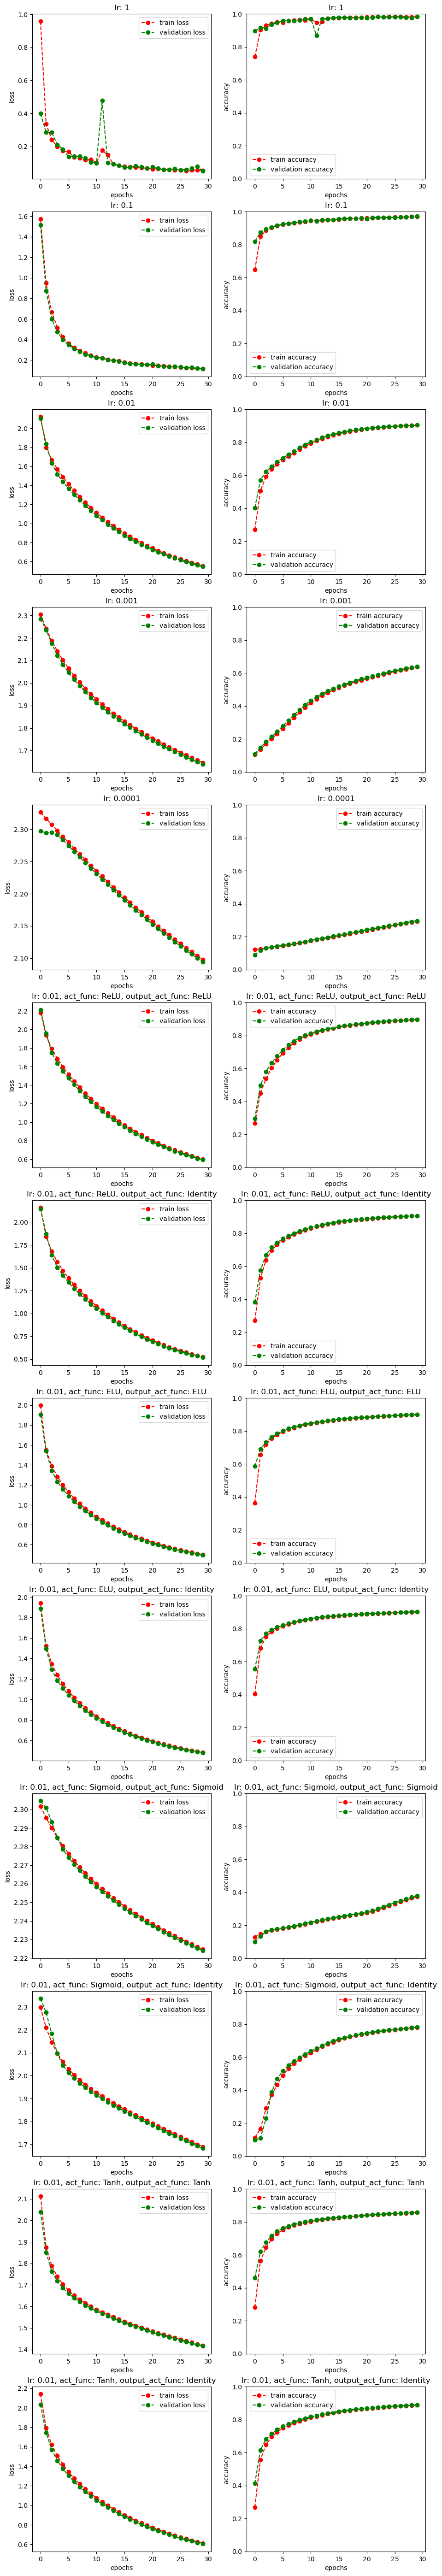

In [20]:
# LUKAS PLOT
num = len(params_list_1)
fig = plt.figure(figsize = (11, 11 * num / 2))

for i, (params, output) in enumerate(zip(params_list_1, output_list_1)):
    plt.subplot(num, 2, 2 * i + 1)
    plt.plot(output[0], linestyle = '--', marker = 'o', label = 'train loss', c = 'r')
    plt.plot(output[2], linestyle = '--', marker = 'o', label = 'validation loss', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    if "act_func" in params.keys():
        act_func = f'act_func: {params["act_func"].__class__.__name__ if params["act_func"] else None}'
        output_act_func = f'output_act_func: {params["output_act_func"].__class__.__name__ if params["output_act_func"] else None}'
        plt.title(', '.join([lr, act_func, output_act_func]))
    else:
        plt.title(lr)
    plt.legend()

    plt.subplot(num, 2, 2 * i + 2)
    plt.plot(output[1], linestyle = '--', marker = 'o', label = 'train accuracy', c = 'r')
    plt.plot(output[3], linestyle = '--', marker = 'o', label = 'validation accuracy', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0,1)
    if "act_func" in params.keys():
        act_func = f'act_func: {params["act_func"].__class__.__name__ if params["act_func"] else None}'
        output_act_func = f'output_act_func: {params["output_act_func"].__class__.__name__ if params["output_act_func"] else None}'
        plt.title(', '.join([lr, act_func, output_act_func]))
    else:
        plt.title(lr)
    plt.legend()

plt.savefig('result_l1.png')
plt.show()

In [21]:
my_model = MLP()
loss_functions = [
    #F.mse_loss :labels as float tensor
    F.l1_loss,
    F.soft_margin_loss, # one hot 
    F.nll_loss, # LogSoftmax  als last layer
    F.cross_entropy,
]

one_hot_enabled = [
    True,
    True,
    False,
    False
]

optim_functions = [
    torch.optim.Adam,
    torch.optim.SGD,
    torch.optim.Adagrad,
]


In [22]:
params_list_2 = []
output_list_2 = []


for loss_func, one_hot in zip(loss_functions, one_hot_enabled):
    for optim in optim_functions:
        print("------------------------------------------------------")
        print(optim, loss_func)
        
        lr = 0.01
        epochs = 30
        if optim == torch.optim.Adam:
            model = MLP(last_layer = torch.nn.LogSoftmax()).to(device)
        else:
            model = MLP().to(device)
        optim = optim(params=model.parameters(), lr=0.01)
        params = dict(model=model, tl=train_loader, vl=test_loader, epochs=epochs, optim=optim, loss_func=loss_func, lr=lr, one_hot=one_hot)
        output = train_and_validate(**params)
        params_list_2.append(params)
        output_list_2.append(output)

print("Done.")

------------------------------------------------------
<class 'torch.optim.adam.Adam'> <function l1_loss at 0x7f767f6b3a30>


/tmp/ipykernel_1902/643251640.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.last_act_fn(self.output_layer(x))


Epoch 1
Average training loss: 2.4174587726593018
Average training accuracy: 0.09474636614322662
Average validation loss: 2.4211649894714355
Average validation accuracy: 0.16259431838989258
----------------------------

Epoch 2
Average training loss: 2.4038443565368652
Average training accuracy: 0.08976079523563385
Average validation loss: 2.4042277336120605
Average validation accuracy: 0.05208941176533699
----------------------------

Epoch 3
Average training loss: 2.4029455184936523
Average training accuracy: 0.12035152316093445
Average validation loss: 2.4030044078826904
Average validation accuracy: 0.09254360944032669
----------------------------

Epoch 4
Average training loss: 2.40273118019104
Average training accuracy: 0.11707160621881485
Average validation loss: 2.402750253677368
Average validation accuracy: 0.11321398615837097
----------------------------

Epoch 5
Average training loss: 2.4026706218719482
Average training accuracy: 0.12134946137666702
Average validation loss: 2

Epoch 8
Average training loss: 0.1967306286096573
Average training accuracy: 0.3919588625431061
Average validation loss: 0.19489826261997223
Average validation accuracy: 0.40170153975486755
----------------------------

Epoch 9
Average training loss: 0.18983937799930573
Average training accuracy: 0.40288734436035156
Average validation loss: 0.18834595382213593
Average validation accuracy: 0.41293004155158997
----------------------------

Epoch 10
Average training loss: 0.1837848573923111
Average training accuracy: 0.4148184359073639
Average validation loss: 0.1823645532131195
Average validation accuracy: 0.42345279455184937
----------------------------

Epoch 11
Average training loss: 0.1785898357629776
Average training accuracy: 0.4226474165916443
Average validation loss: 0.17741328477859497
Average validation accuracy: 0.43114057183265686
----------------------------

Epoch 12
Average training loss: 0.17401406168937683
Average training accuracy: 0.4307824969291687
Average validation 

Epoch 15
Average training loss: 0.0786566361784935
Average training accuracy: 0.668567419052124
Average validation loss: 0.07761380076408386
Average validation accuracy: 0.676232099533081
----------------------------

Epoch 16
Average training loss: 0.07750243693590164
Average training accuracy: 0.6723944544792175
Average validation loss: 0.07753246277570724
Average validation accuracy: 0.6695361733436584
----------------------------

Epoch 17
Average training loss: 0.07677702605724335
Average training accuracy: 0.6745019555091858
Average validation loss: 0.075749970972538
Average validation accuracy: 0.6593426465988159
----------------------------

Epoch 18
Average training loss: 0.07597437500953674
Average training accuracy: 0.6773386597633362
Average validation loss: 0.07522687315940857
Average validation accuracy: 0.6673954129219055
----------------------------

Epoch 19
Average training loss: 0.07517584413290024
Average training accuracy: 0.6804977655410767
Average validation loss

Epoch 22
Average training loss: 0.697870135307312
Average training accuracy: 0.9777265191078186
Average validation loss: 0.6975011229515076
Average validation accuracy: 0.9800669550895691
----------------------------

Epoch 23
Average training loss: 0.69758540391922
Average training accuracy: 0.9794115424156189
Average validation loss: 0.697550356388092
Average validation accuracy: 0.9791213870048523
----------------------------

Epoch 24
Average training loss: 0.6974585652351379
Average training accuracy: 0.9796735644340515
Average validation loss: 0.697097897529602
Average validation accuracy: 0.9817047119140625
----------------------------

Epoch 25
Average training loss: 0.6972053050994873
Average training accuracy: 0.9815276861190796
Average validation loss: 0.6977880001068115
Average validation accuracy: 0.9776579141616821
----------------------------

Epoch 26
Average training loss: 0.6971061825752258
Average training accuracy: 0.9818063378334045
Average validation loss: 0.69708

Epoch 29
Average training loss: 0.6662744879722595
Average training accuracy: 0.4125162661075592
Average validation loss: 0.666050910949707
Average validation accuracy: 0.4149710237979889
----------------------------

Epoch 30
Average training loss: 0.6658992171287537
Average training accuracy: 0.41664981842041016
Average validation loss: 0.6656696200370789
Average validation accuracy: 0.419495165348053
----------------------------

------------------------------------------------------
<class 'torch.optim.adagrad.Adagrad'> <function soft_margin_loss at 0x7f767f6b3eb0>
Epoch 1
Average training loss: 0.6520815491676331
Average training accuracy: 0.6715046167373657
Average validation loss: 0.6441676616668701
Average validation accuracy: 0.7851136326789856
----------------------------

Epoch 2
Average training loss: 0.6363373398780823
Average training accuracy: 0.8223495483398438
Average validation loss: 0.6353134512901306
Average validation accuracy: 0.8393587470054626
------------------

Average validation loss: 0.18814809620380402
Average validation accuracy: 0.9463436007499695
----------------------------

Epoch 6
Average training loss: 0.17500503361225128
Average training accuracy: 0.949347198009491
Average validation loss: 0.17997869849205017
Average validation accuracy: 0.9491825103759766
----------------------------

Epoch 7
Average training loss: 0.15566836297512054
Average training accuracy: 0.9544274806976318
Average validation loss: 0.14759622514247894
Average validation accuracy: 0.9565678834915161
----------------------------

Epoch 8
Average training loss: 0.14002661406993866
Average training accuracy: 0.9586932063102722
Average validation loss: 0.13487158715724945
Average validation accuracy: 0.9592718482017517
----------------------------

Epoch 9
Average training loss: 0.12710978090763092
Average training accuracy: 0.9619436860084534
Average validation loss: 0.13106569647789001
Average validation accuracy: 0.960250973701477
----------------------------


Average validation loss: -4.7482404708862305
Average validation accuracy: 0.5565096735954285
----------------------------

Epoch 13
Average training loss: -4.95278787612915
Average training accuracy: 0.5604433417320251
Average validation loss: -5.3132171630859375
Average validation accuracy: 0.5600759983062744
----------------------------

Epoch 14
Average training loss: -5.501597881317139
Average training accuracy: 0.5654604434967041
Average validation loss: -5.880082130432129
Average validation accuracy: 0.5692488551139832
----------------------------

Epoch 15
Average training loss: -6.106843948364258
Average training accuracy: 0.5727527737617493
Average validation loss: -6.5392327308654785
Average validation accuracy: 0.5738773345947266
----------------------------

Epoch 16
Average training loss: -6.759247779846191
Average training accuracy: 0.5801365375518799
Average validation loss: -7.207799911499023
Average validation accuracy: 0.5818802714347839
----------------------------



Average validation loss: -11.93641471862793
Average validation accuracy: 0.8916047215461731
----------------------------

Epoch 20
Average training loss: -12.177759170532227
Average training accuracy: 0.890579342842102
Average validation loss: -12.33934211730957
Average validation accuracy: 0.8886057734489441
----------------------------

Epoch 21
Average training loss: -12.611769676208496
Average training accuracy: 0.8916149139404297
Average validation loss: -12.81378173828125
Average validation accuracy: 0.8900692462921143
----------------------------

Epoch 22
Average training loss: -13.041543960571289
Average training accuracy: 0.8925209045410156
Average validation loss: -13.335018157958984
Average validation accuracy: 0.896655797958374
----------------------------

Epoch 23
Average training loss: -13.491520881652832
Average training accuracy: 0.8959266543388367
Average validation loss: -13.616236686706543
Average validation accuracy: 0.8959859013557434
----------------------------

Average validation loss: 0.04028917849063873
Average validation accuracy: 0.988600492477417
----------------------------

Epoch 27
Average training loss: 0.04110009968280792
Average training accuracy: 0.9880700707435608
Average validation loss: 0.04638870432972908
Average validation accuracy: 0.9852575659751892
----------------------------

Epoch 28
Average training loss: 0.04061686620116234
Average training accuracy: 0.987908661365509
Average validation loss: 0.03630439192056656
Average validation accuracy: 0.989708662033081
----------------------------

Epoch 29
Average training loss: 0.03849250078201294
Average training accuracy: 0.9886220097541809
Average validation loss: 0.041304294019937515
Average validation accuracy: 0.9875627756118774
----------------------------

Epoch 30
Average training loss: 0.037327952682971954
Average training accuracy: 0.9893186092376709
Average validation loss: 0.036383725702762604
Average validation accuracy: 0.9898585081100464
-----------------------

Epoch 3
Average training loss: 0.6134923696517944
Average training accuracy: 0.8980725407600403
Average validation loss: 0.5809648633003235
Average validation accuracy: 0.8869019150733948
----------------------------

Epoch 4
Average training loss: 0.5087238550186157
Average training accuracy: 0.9079219102859497
Average validation loss: 0.49221161007881165
Average validation accuracy: 0.9126262664794922
----------------------------

Epoch 5
Average training loss: 0.43693479895591736
Average training accuracy: 0.9160213470458984
Average validation loss: 0.4225951135158539
Average validation accuracy: 0.9173892736434937
----------------------------

Epoch 6
Average training loss: 0.39230650663375854
Average training accuracy: 0.9203718900680542
Average validation loss: 0.38000980019569397
Average validation accuracy: 0.9243554472923279
----------------------------

Epoch 7
Average training loss: 0.357075572013855
Average training accuracy: 0.9252325892448425
Average validation loss: 0.36

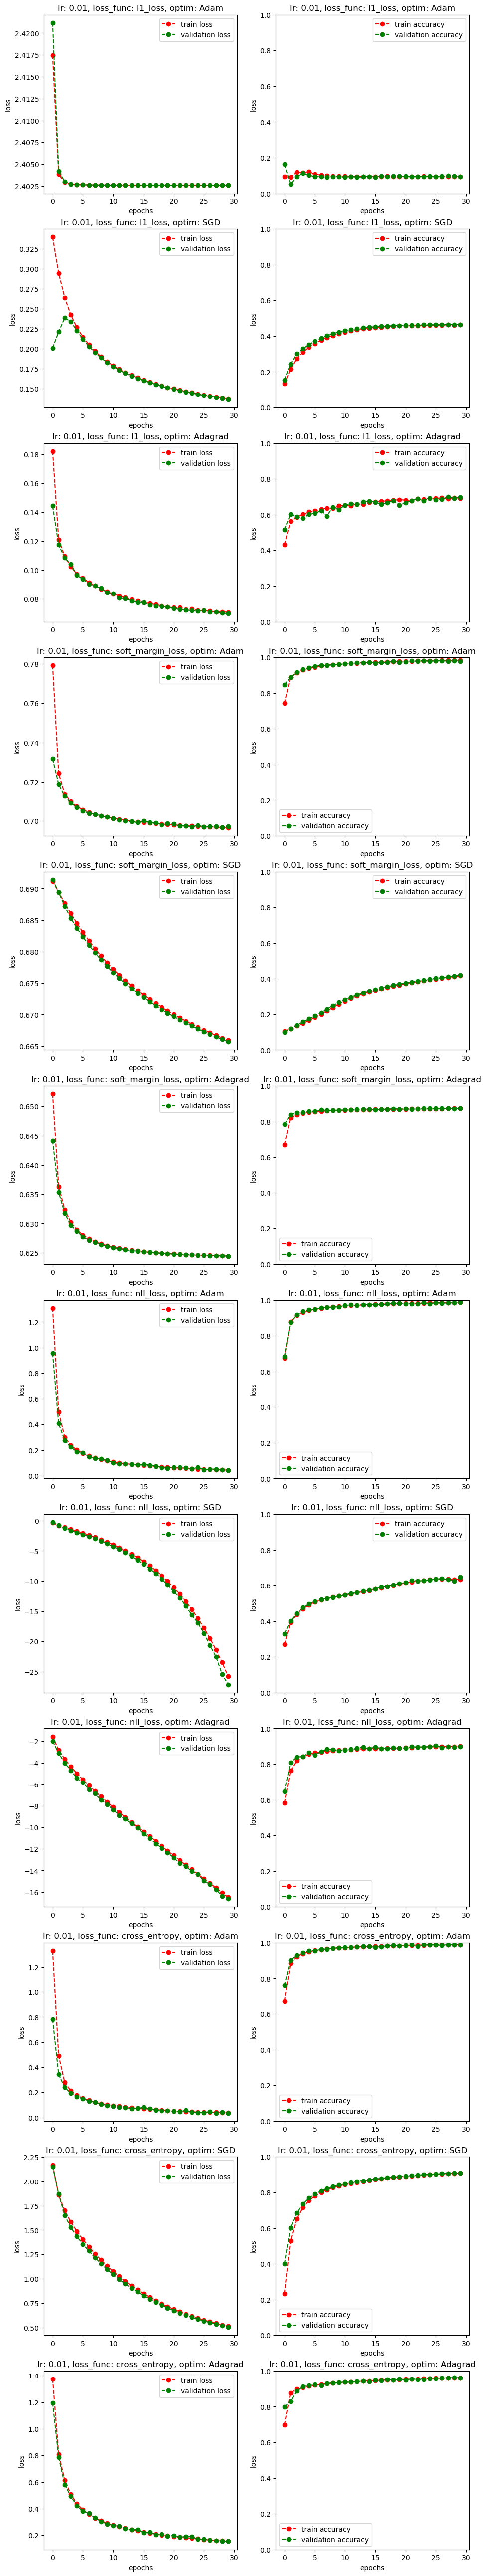

In [23]:
num = len(params_list_2)
fig = plt.figure(figsize = (11, 11 * num / 2))

for i, (params, output) in enumerate(zip(params_list_2, output_list_2)):
    plt.subplot(num, 2, 2 * i + 1)
    plt.plot(output[0], linestyle = '--', marker = 'o', label = 'train loss', c = 'r')
    plt.plot(output[2], linestyle = '--', marker = 'o', label = 'validation loss', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    lr = f'lr: {params["lr"]}'
    loss_func = f'loss_func: {params["loss_func"].__name__ if params["loss_func"] else None}'
    optim = f'optim: {params["optim"].__class__.__name__ if params["optim"] else None}'
    plt.title(', '.join([lr, loss_func, optim]))
    plt.legend()

    plt.subplot(num, 2, 2 * i + 2)
    plt.plot(output[1], linestyle = '--', marker = 'o', label = 'train accuracy', c = 'r')
    plt.plot(output[3], linestyle = '--', marker = 'o', label = 'validation accuracy', c = 'g')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0,1)
    lr = f'lr: {params["lr"]}'
    loss_func = f'loss_func: {params["loss_func"].__name__ if params["loss_func"] else None}'
    optim = f'optim: {params["optim"].__class__.__name__ if params["optim"] else None}'
    plt.title(', '.join([lr, loss_func, optim]))
    plt.legend()
    
plt.savefig('result_2.png')
plt.show()


## Changing number of hidden layers to [1, 3, 5, 7]

In [24]:
########################
## Hidden Layers = 1 ##
########################
lr1 = 0.01
mlpModel1 = MLP().to(device)
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=mlpModel1.parameters(), lr=lr1)
losses_1_layers, val_loss_1_layers, acc_train_1_layers, acc_val_1_layers = train_and_validate(mlpModel1, train_loader, test_loader, epochs, optim, loss_func, True)

Epoch 1
Average training loss: 1.3519480228424072
Average training accuracy: 0.7058889865875244
Average validation loss: 0.8641257882118225
Average validation accuracy: 0.7262853980064392
----------------------------

Epoch 2
Average training loss: 0.4971863031387329
Average training accuracy: 0.8854994177818298
Average validation loss: 0.4043276607990265
Average validation accuracy: 0.880024790763855
----------------------------

Epoch 3
Average training loss: 0.29173019528388977
Average training accuracy: 0.9172502756118774
Average validation loss: 0.27595362067222595
Average validation accuracy: 0.920045018196106
----------------------------

Epoch 4
Average training loss: 0.2257634848356247
Average training accuracy: 0.9347091913223267
Average validation loss: 0.23491829633712769
Average validation accuracy: 0.9314166903495789
----------------------------

Epoch 5
Average training loss: 0.1905699074268341
Average training accuracy: 0.9456539154052734
Average validation loss: 0.1841

In [25]:
########################
## Hidden Layers = 3 ##
########################

mlpModel3 = MLP(num_hidden_units=30, hidden_layers=3).to(device)
optim = torch.optim.Adam(params=mlpModel3.parameters(), lr=lr1)
losses_3_layers, val_loss_3_layers, acc_train_3_layers, acc_val_3_layers = train_and_validate(mlpModel3, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 1.3048845529556274
Average training accuracy: 0.6879886388778687
Average validation loss: 0.8597431182861328
Average validation accuracy: 0.8135445713996887
----------------------------

Epoch 2
Average training loss: 0.3705897331237793
Average training accuracy: 0.9121133089065552
Average validation loss: 0.3234357237815857
Average validation accuracy: 0.9057352542877197
----------------------------

Epoch 3
Average training loss: 0.21141213178634644
Average training accuracy: 0.9387623071670532
Average validation loss: 0.22641150653362274
Average validation accuracy: 0.9318177103996277
----------------------------

Epoch 4
Average training loss: 0.16541685163974762
Average training accuracy: 0.9523951411247253
Average validation loss: 0.16711966693401337
Average validation accuracy: 0.9496923089027405
----------------------------

Epoch 5
Average training loss: 0.13844077289104462
Average training accuracy: 0.9596481323242188
Average validation loss: 0.

In [26]:
########################
## Hidden Layers = 5 ##
########################

mlpModel5 = MLP(num_hidden_units=30,  hidden_layers=5).to(device)
optim = torch.optim.Adam(params=mlpModel5.parameters(), lr=lr1)
losses_5_layers, val_loss_5_layers, acc_train_5_layers, acc_val_5_layers = train_and_validate(mlpModel5, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 1.367943286895752
Average training accuracy: 0.6171988844871521
Average validation loss: 1.1582047939300537
Average validation accuracy: 0.7178410887718201
----------------------------

Epoch 2
Average training loss: 0.43267935514450073
Average training accuracy: 0.8859533667564392
Average validation loss: 0.40670615434646606
Average validation accuracy: 0.8823697566986084
----------------------------

Epoch 3
Average training loss: 0.2451038360595703
Average training accuracy: 0.929840087890625
Average validation loss: 0.2372596263885498
Average validation accuracy: 0.9315168857574463
----------------------------

Epoch 4
Average training loss: 0.18299128115177155
Average training accuracy: 0.9478415250778198
Average validation loss: 0.16631080210208893
Average validation accuracy: 0.9524092078208923
----------------------------

Epoch 5
Average training loss: 0.1519462764263153
Average training accuracy: 0.9557913541793823
Average validation loss: 0.161

In [27]:
########################
## Hidden Layers = 7 ##
########################

mlpModel7 = MLP(num_hidden_units=30,  hidden_layers=7).to(device)
optim = torch.optim.Adam(params=mlpModel7.parameters(), lr=lr1)
losses_7_layers, val_loss_7_layers, acc_train_7_layers, acc_val_7_layers = train_and_validate(mlpModel7, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 1.3774381875991821
Average training accuracy: 0.6093665957450867
Average validation loss: 1.5591468811035156
Average validation accuracy: 0.6285756230354309
----------------------------

Epoch 2
Average training loss: 0.39047321677207947
Average training accuracy: 0.8997393846511841
Average validation loss: 0.554168701171875
Average validation accuracy: 0.8446922302246094
----------------------------

Epoch 3
Average training loss: 0.23915447294712067
Average training accuracy: 0.933392345905304
Average validation loss: 0.3122645318508148
Average validation accuracy: 0.9119424819946289
----------------------------

Epoch 4
Average training loss: 0.18176670372486115
Average training accuracy: 0.9481979012489319
Average validation loss: 0.19353166222572327
Average validation accuracy: 0.9442324042320251
----------------------------

Epoch 5
Average training loss: 0.14975008368492126
Average training accuracy: 0.956866979598999
Average validation loss: 0.170

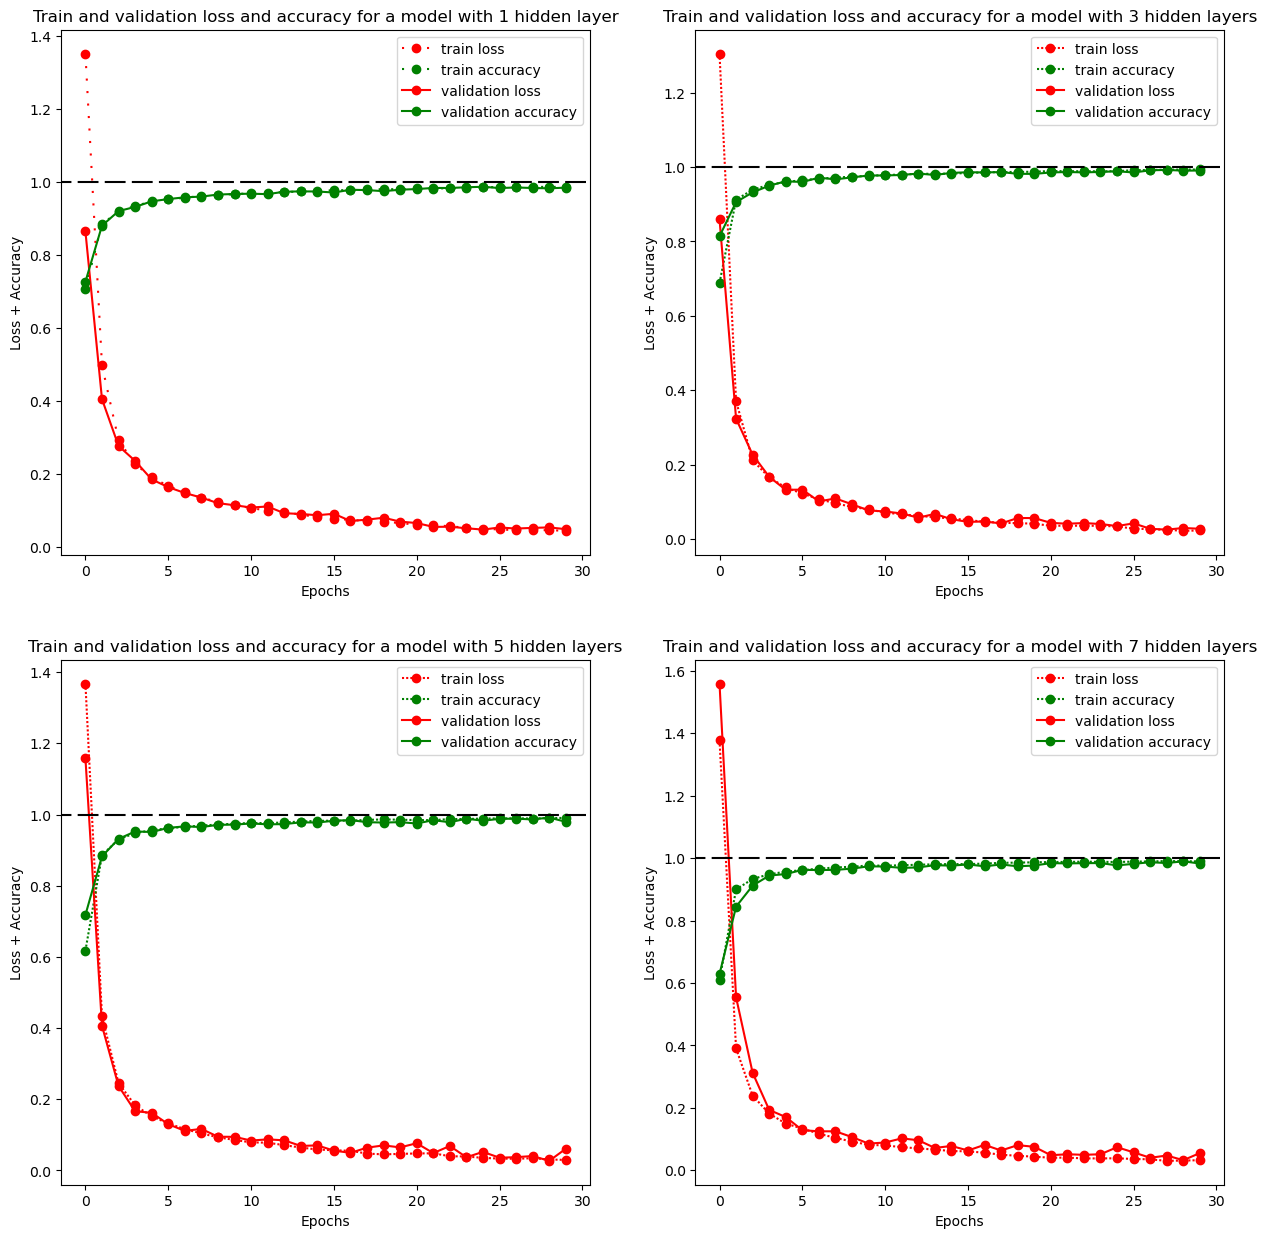

In [45]:
fig, axs = plt.subplots(2,2, figsize=(15,15)) 
axs[0,0].plot(losses_1_layers, linestyle = (0, (1, 5)), marker = 'o', label = 'train loss', c = 'r')
axs[0,0].plot(val_loss_1_layers, linestyle = (0, (1, 5)), marker = 'o', label = 'train accuracy', c = 'g')
axs[0,0].plot(acc_train_1_layers, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[0,0].plot(acc_val_1_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[0,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss + Accuracy")
axs[0,0].set_title("Train and validation loss and accuracy for a model with 1 hidden layer")
axs[0,0].legend()

axs[0,1].plot(losses_3_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,1].plot(val_loss_3_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train accuracy', c = 'g')
axs[0,1].plot(acc_train_3_layers, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[0,1].plot(acc_val_3_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[0,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss + Accuracy")
axs[0,1].set_title("Train and validation loss and accuracy for a model with 3 hidden layers")
axs[0,1].legend()

axs[1,0].plot(losses_5_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,0].plot(val_loss_5_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train accuracy', c = 'g')
axs[1,0].plot(acc_train_5_layers, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[1,0].plot(acc_val_5_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[1,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss + Accuracy")
axs[1,0].set_title("Train and validation loss and accuracy for a model with 5 hidden layers")
axs[1,0].legend()

axs[1,1].plot(losses_7_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,1].plot(val_loss_7_layers, linestyle = (0, (1, 1)), marker = 'o', label = 'train accuracy', c = 'g')
axs[1,1].plot(acc_train_7_layers, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[1,1].plot(acc_val_7_layers, linestyle = '-', marker = 'o', label = 'validation accuracy', c = 'g')
axs[1,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Loss + Accuracy")
axs[1,1].set_title("Train and validation loss and accuracy for a model with 7 hidden layers")
axs[1,1].legend()


## Changing number of Hidden units per layer to [30, 60, 128, 256]

In [29]:
############################
## Number of Neurons = 30 ##
############################

mlpModel30 = MLP(num_hidden_units=30).to(device)
optim = torch.optim.Adam(params=mlpModel30.parameters(), lr=lr1)
losses_30n, val_loss_30n, acc_30n, val_acc_30n = train_and_validate(mlpModel30, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 1.2571685314178467
Average training accuracy: 0.7042915225028992
Average validation loss: 0.7370415329933167
Average validation accuracy: 0.7778040170669556
----------------------------

Epoch 2
Average training loss: 0.48555681109428406
Average training accuracy: 0.8791529536247253
Average validation loss: 0.3837359845638275
Average validation accuracy: 0.8850325345993042
----------------------------

Epoch 3
Average training loss: 0.30575400590896606
Average training accuracy: 0.9117679595947266
Average validation loss: 0.29331091046333313
Average validation accuracy: 0.9120756983757019
----------------------------

Epoch 4
Average training loss: 0.24470187723636627
Average training accuracy: 0.9285311102867126
Average validation loss: 0.25794297456741333
Average validation accuracy: 0.9230993986129761
----------------------------

Epoch 5
Average training loss: 0.2072441577911377
Average training accuracy: 0.939852774143219
Average validation loss: 0.2

In [30]:
############################
## Number of Neurons = 60 ##
############################

mlpModel60 = MLP(num_hidden_units=60).to(device)
optim = torch.optim.Adam(params=mlpModel60.parameters(), lr=lr1)
losses_60n, val_loss_60n, acc_60n, val_acc_60n = train_and_validate(mlpModel60, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 0.9178188443183899
Average training accuracy: 0.7765003442764282
Average validation loss: 0.5197433829307556
Average validation accuracy: 0.8377439379692078
----------------------------

Epoch 2
Average training loss: 0.2990320324897766
Average training accuracy: 0.9131000638008118
Average validation loss: 0.271463543176651
Average validation accuracy: 0.9162634611129761
----------------------------

Epoch 3
Average training loss: 0.21230895817279816
Average training accuracy: 0.9354682564735413
Average validation loss: 0.20886193215847015
Average validation accuracy: 0.9354889988899231
----------------------------

Epoch 4
Average training loss: 0.16593626141548157
Average training accuracy: 0.9506177306175232
Average validation loss: 0.1584729552268982
Average validation accuracy: 0.9528399109840393
----------------------------

Epoch 5
Average training loss: 0.1335453987121582
Average training accuracy: 0.9606274962425232
Average validation loss: 0.127

In [31]:
############################
## Number of Neurons = 128 ##
############################

mlpModel128 = MLP(num_hidden_units=128).to(device)
optim = torch.optim.Adam(params=mlpModel128.parameters(), lr=lr1)
losses_128n, val_loss_128n, acc_128n, val_acc_128n = train_and_validate(mlpModel128, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 0.6972777843475342
Average training accuracy: 0.7959345579147339
Average validation loss: 0.4819946885108948
Average validation accuracy: 0.8644462823867798
----------------------------

Epoch 2
Average training loss: 0.23740778863430023
Average training accuracy: 0.9281136393547058
Average validation loss: 0.21938185393810272
Average validation accuracy: 0.9346415400505066
----------------------------

Epoch 3
Average training loss: 0.1670181006193161
Average training accuracy: 0.9500437378883362
Average validation loss: 0.17026948928833008
Average validation accuracy: 0.9474001526832581
----------------------------

Epoch 4
Average training loss: 0.12484852224588394
Average training accuracy: 0.961968183517456
Average validation loss: 0.1245768740773201
Average validation accuracy: 0.9623907804489136
----------------------------

Epoch 5
Average training loss: 0.09809283912181854
Average training accuracy: 0.9714344143867493
Average validation loss: 0.0

In [32]:
############################
## Number of Neurons = 256 ##
############################

mlpModel256 = MLP(num_hidden_units=256).to(device)
optim = torch.optim.Adam(params=mlpModel256.parameters(), lr=lr1)
losses_256n, val_loss_256n, acc_256n, val_acc_256n = train_and_validate(mlpModel256, train_loader, test_loader, epochs, optim, loss_func)

Epoch 1
Average training loss: 0.5430269837379456
Average training accuracy: 0.8290421962738037
Average validation loss: 0.41649335622787476
Average validation accuracy: 0.8853456974029541
----------------------------

Epoch 2
Average training loss: 0.19732387363910675
Average training accuracy: 0.9406253695487976
Average validation loss: 0.18823833763599396
Average validation accuracy: 0.9435664415359497
----------------------------

Epoch 3
Average training loss: 0.13984160125255585
Average training accuracy: 0.9578718543052673
Average validation loss: 0.1269325613975525
Average validation accuracy: 0.9605996608734131
----------------------------

Epoch 4
Average training loss: 0.10655011981725693
Average training accuracy: 0.9678546190261841
Average validation loss: 0.10836558789014816
Average validation accuracy: 0.965833842754364
----------------------------

Epoch 5
Average training loss: 0.08110785484313965
Average training accuracy: 0.9751039147377014
Average validation loss: 0

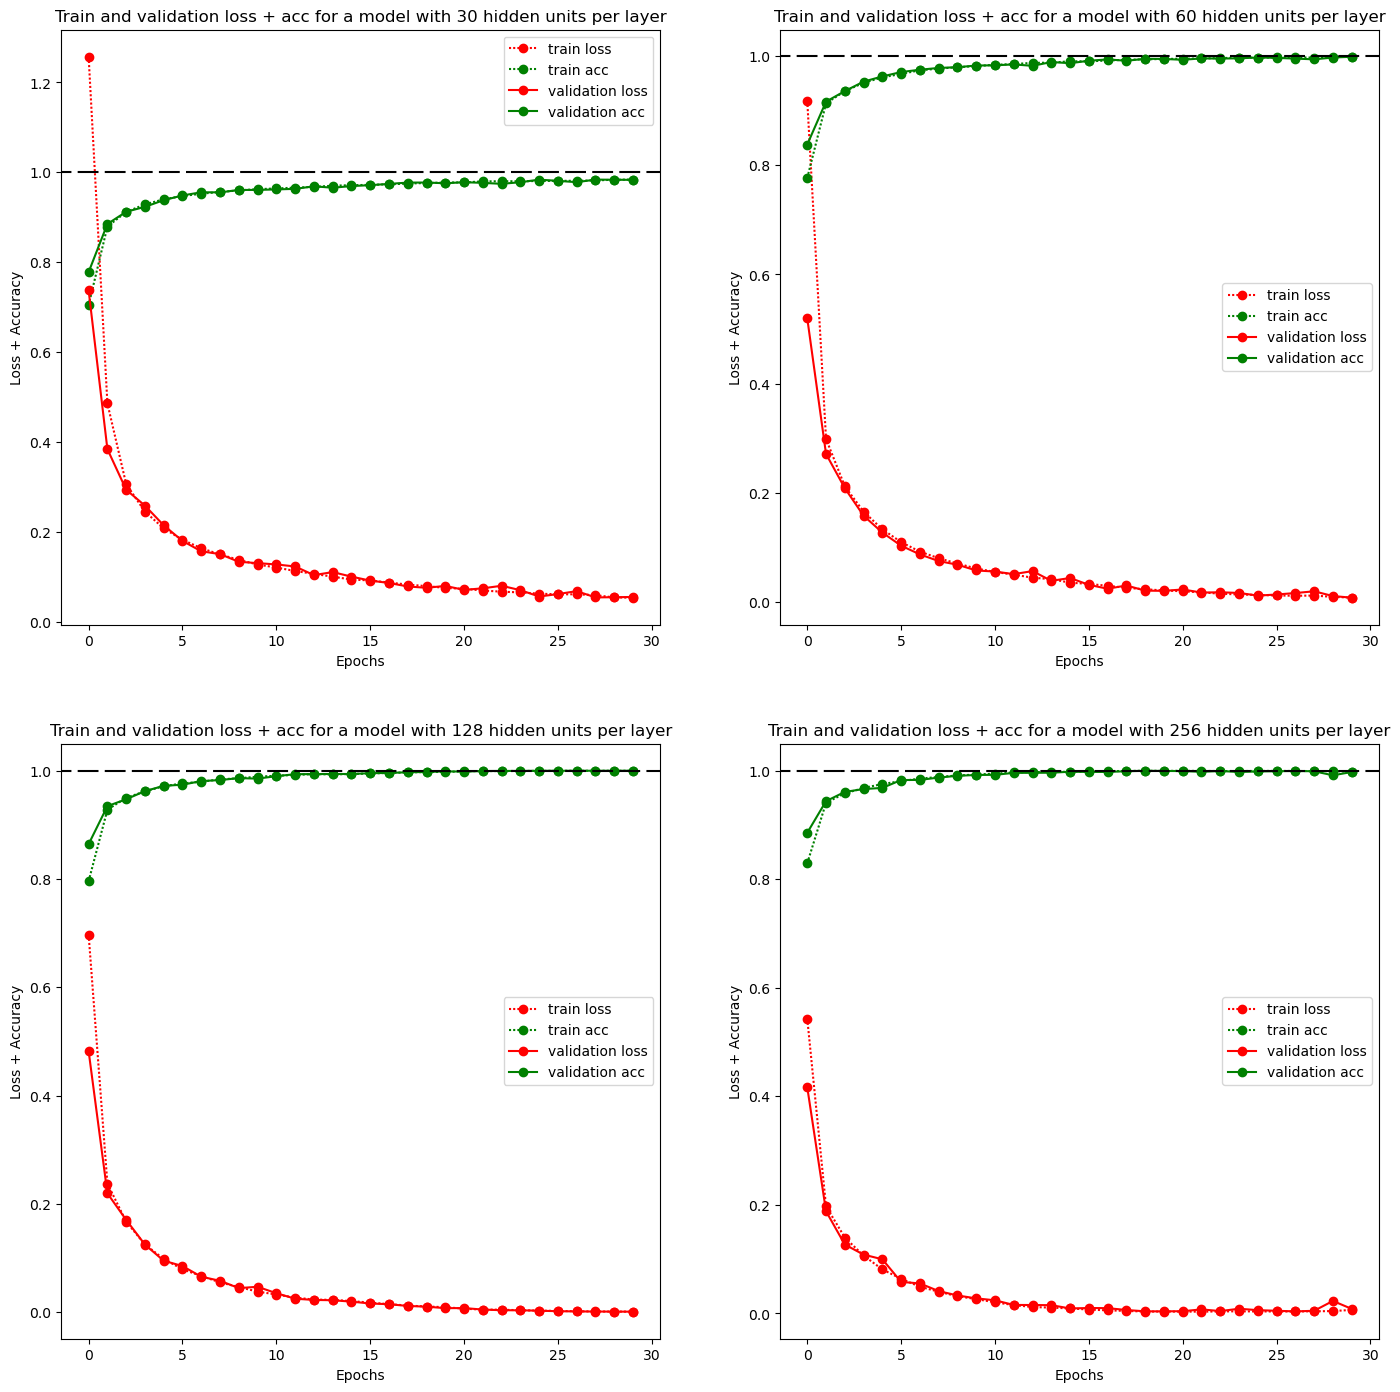

In [46]:
fig, axs = plt.subplots(2,2, figsize=(17,17))
axs[0,0].plot(losses_30n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,0].plot(val_loss_30n, linestyle = (0, (1, 1)), marker = 'o', label = 'train acc', c = 'g')
axs[0,0].plot(acc_30n, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[0,0].plot(val_acc_30n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[0,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Loss + Accuracy")
axs[0,0].set_title("Train and validation loss + acc for a model with 30 hidden units per layer")
axs[0,0].legend()

axs[0,1].plot(losses_60n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[0,1].plot(val_loss_60n, linestyle = (0, (1, 1)), marker = 'o', label = 'train acc', c = 'g')
axs[0,1].plot(acc_60n, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[0,1].plot(val_acc_60n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[0,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Loss + Accuracy")
axs[0,1].set_title("Train and validation loss + acc for a model with 60 hidden units per layer")
axs[0,1].legend()

axs[1,0].plot(losses_128n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,0].plot(val_loss_128n, linestyle = (0, (1, 1)), marker = 'o', label = 'train acc', c = 'g')
axs[1,0].plot(acc_128n, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[1,0].plot(val_acc_128n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[1,0].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss + Accuracy")
axs[1,0].set_title("Train and validation loss + acc for a model with 128 hidden units per layer")
axs[1,0].legend()

axs[1,1].plot(losses_256n, linestyle = (0, (1, 1)), marker = 'o', label = 'train loss', c = 'r')
axs[1,1].plot(val_loss_256n, linestyle = (0, (1, 1)), marker = 'o', label = 'train acc', c = 'g')
axs[1,1].plot(acc_256n, linestyle = '-', marker = 'o', label = 'validation loss', c = 'r')
axs[1,1].plot(val_acc_256n, linestyle = '-', marker = 'o', label = 'validation acc', c = 'g')
axs[1,1].axhline(y=1, color='black', linestyle=(5, (10, 3)))
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Loss + Accuracy")
axs[1,1].set_title("Train and validation loss + acc for a model with 256 hidden units per layer")
axs[1,1].legend()

plt.savefig("hidden_units")
plt.show()

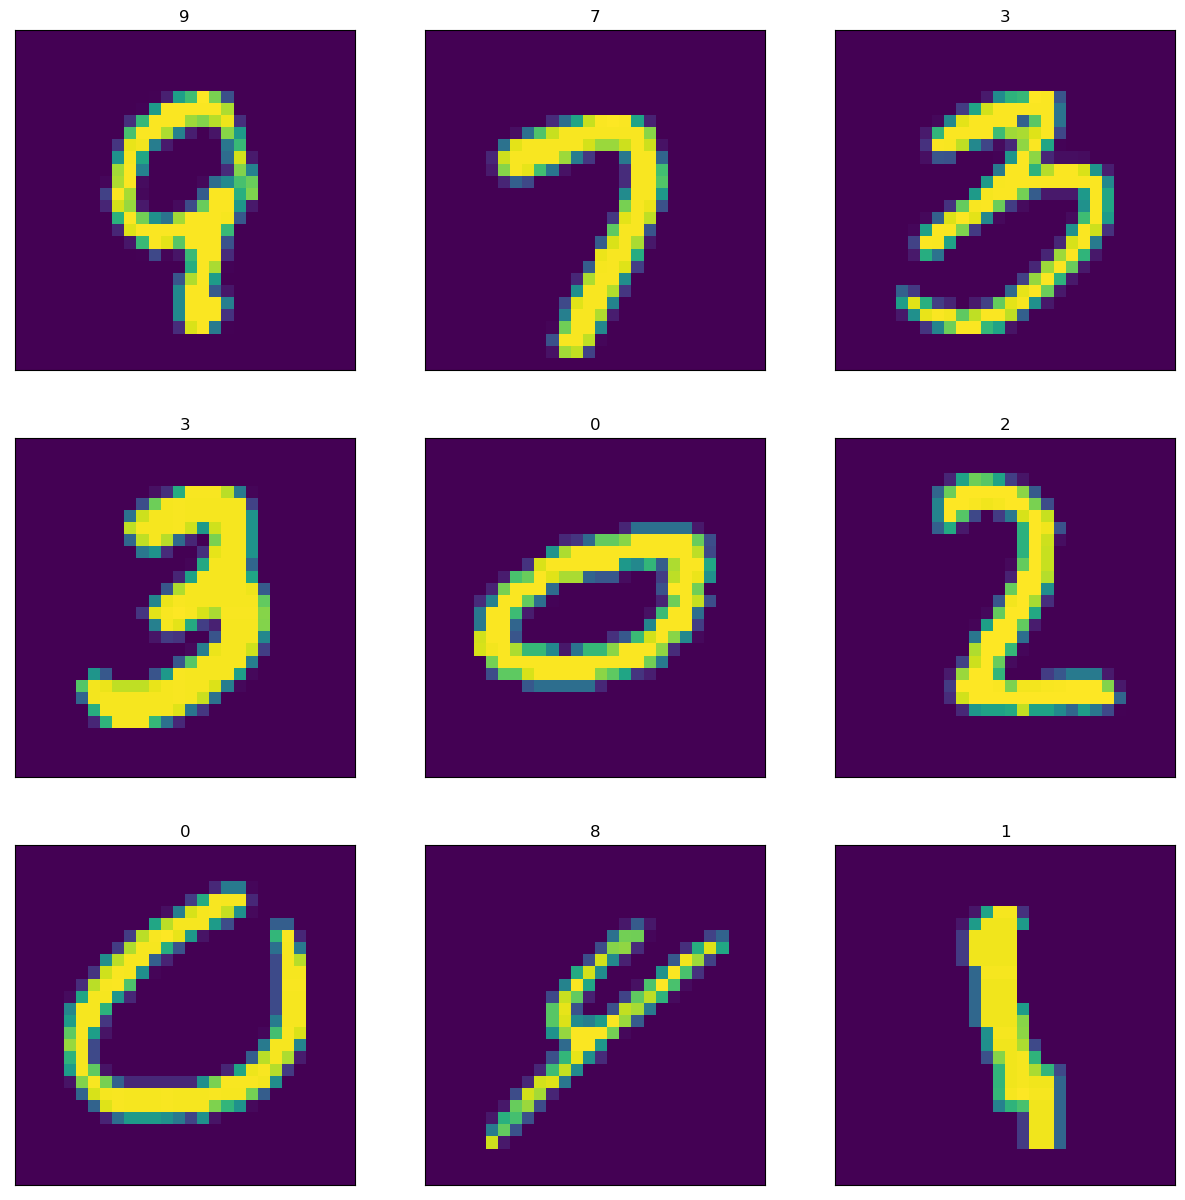

In [34]:
show_multiple_predictions(mlpModel1, test_dataset) 

### Aufgabe 5

In [35]:
import glob
import os
from PIL import Image

In [36]:
main_path = "./chest_xray"
data_normal = glob.glob(main_path+"/**/NORMAL*.jpeg", recursive=True)
data_virus = glob.glob(main_path+"/**/VIRUS*.jpeg", recursive=True)
data_bacteria = glob.glob(main_path+"/**/BACTERIA*.jpeg", recursive=True)
data_bacteria[:5]

['./chest_xray/test/PNEUMONIA/BACTERIA-6950003-0005.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-3961172-0001.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-9364007-0001.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-2034017-0002.jpeg',
 './chest_xray/test/PNEUMONIA/BACTERIA-5489623-0002.jpeg']

In [37]:
def loaders_from_ds(ds, split=0.8, batch_size=32):
    train_set_size = int(split * len(ds))
    val_set_size = len(ds) - train_set_size
    ts, vs = torch.utils.data.random_split(ds, lengths=[train_set_size, val_set_size])
    
    train_loader = torch.utils.data.DataLoader(ts, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(vs, batch_size=batch_size, shuffle=True)
    
    return train_loader, val_loader

In [38]:
class TrainDataSet(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs):
        super().__init__()
        main_path = "./chest_xray"
        data_normal = glob.glob(main_path+"/**/NORMAL*.jpeg", recursive=True)
        data_virus = glob.glob(main_path+"/**/VIRUS*.jpeg", recursive=True)
        data_bacteria = glob.glob(main_path+"/**/BACTERIA*.jpeg", recursive=True)
        self.data = pd.DataFrame(np.concatenate([['NORMAL'] * len(data_normal), ['VIRUS'] * len(data_virus), ['BACTERIA'] * len(data_bacteria)]), columns = ['class'])
        data_all = []
        data_all.extend(data_normal)
        data_all.extend(data_virus)
        data_all.extend(data_bacteria)
        self.data['image'] = data_all
        self.class_to_idx = {'NORMAL': 0, 'VIRUS': 1, 'BACTERIA': 2}
        self.classes = {v: k for k, v in self.class_to_idx.items()}
        
    def __getitem__(self, index):
        x = self.data['image'][index]
        y = self.data['class'][index]
        y = self.class_to_idx[y]
        with Image.open(x) as x2:
            x2 = x2.resize((200, 200), Image.Resampling.LANCZOS)
            x2 = x2.convert('L')
            x2 = torchvision.transforms.ToTensor()(x2)
            x2 = torchvision.transforms.Normalize((0.48187217116355896,),(0.2370065301656723,))(x2)
        return x2, y
    
    def __len__(self):
        return len(self.data)

In [39]:
def select_device(use_cuda=True):
    use_cuda = use_cuda and torch.cuda.is_available()
    name = 'cuda:0' if use_cuda else 'cpu'
    return torch.device(name)

def loaders_from_dataset(dataset, device, split=0.8, batch_size=256):
    ''' This might look redundant, but allows the data to always be on the gpu. '''
    tn = int(split * len(dataset))
    vn = len(dataset) - tn
    ts, vs = torch.utils.data.random_split(dataset, lengths=[tn, vn])
    tl = torch.utils.data.DataLoader(ts, shuffle=True, batch_size=len(ts))
    vl = torch.utils.data.DataLoader(vs, shuffle=False, batch_size=len(vs))
    _, (tx, ty) = next(enumerate(tl))
    _, (vx, vy) = next(enumerate(vl))    
    ts = torch.utils.data.TensorDataset(tx.to(device), ty.to(device)) 
    vs = torch.utils.data.TensorDataset(vx.to(device), vy.to(device))
    params = dict(batch_size=batch_size)
    tl = torch.utils.data.DataLoader(ts, shuffle=True, **params)
    vl = torch.utils.data.DataLoader(vs, shuffle=False, **params)
    return tl, vl

In [40]:
ds = TrainDataSet()
tl, vl = loaders_from_dataset(ds, batch_size=256, device=select_device())
test_batch = next(iter(tl))

In [41]:
test_batch[0][0].size(), test_batch[1][0], test_batch[0][0][0,100:200,100:200], tl.dataset.tensors[0].size()

(torch.Size([1, 200, 200]),
 tensor(0, device='cuda:0'),
 tensor([[ 1.3092,  1.3092,  1.3092,  ..., -1.9173, -1.9835, -2.0332],
         [ 1.3919,  1.3588,  1.3257,  ..., -1.9173, -1.9835, -2.0332],
         [ 1.4581,  1.4746,  1.4581,  ..., -1.9173, -1.9835, -2.0332],
         ...,
         [ 1.5574,  1.5739,  1.6070,  ..., -2.0166, -2.0332, -2.0332],
         [-1.2224, -1.2224, -1.2224,  ..., -2.0166, -2.0332, -2.0332],
         [-2.0332, -2.0332, -2.0332,  ..., -2.0166, -2.0332, -2.0332]],
        device='cuda:0'),
 torch.Size([4684, 1, 200, 200]))

In [42]:
print(f"Mean: {tl.dataset.tensors[0].mean()}")
print(f"Standard deviation: {tl.dataset.tensors[0].var().sqrt()}")
# Hier sehen wir auch das Method-Chaining von PyTorch in Aktion.

Mean: -0.0036047508474439383
Standard deviation: 1.0005269050598145


In [43]:
lr = 0.001
epochs = 30
model = MLP(start_dim = 200 * 200, out_dim = 3, num_hidden_units = 256, hidden_layers = 20, num_hidden_units_factor = 2).to(device)
print(model)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_func = F.cross_entropy
params = dict(model=model, tl=tl, vl=vl, epochs=epochs, optim=optim, loss_func=loss_func, lr=lr)
output = train_and_validate(**params)


MLP(
  (flatten): MyFlatten()
  (last_act_fn): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=40000, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=32, out_features=16, bias=True)
    (12): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Linear(in_features=16, out_features=8, bias=True)
    (15): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    

Epoch 23
Average training loss: 0.9504349231719971
Average training accuracy: 0.5558885931968689
Average validation loss: 0.9370112419128418
Average validation accuracy: 0.5866131782531738
----------------------------

Epoch 24
Average training loss: 0.9327560067176819
Average training accuracy: 0.5740780830383301
Average validation loss: 0.9323723912239075
Average validation accuracy: 0.5805743336677551
----------------------------

Epoch 25
Average training loss: 0.923403799533844
Average training accuracy: 0.5810897946357727
Average validation loss: 0.9098079800605774
Average validation accuracy: 0.5964949727058411
----------------------------

Epoch 26
Average training loss: 0.911030113697052
Average training accuracy: 0.6071567535400391
Average validation loss: 0.8819174766540527
Average validation accuracy: 0.6294552087783813
----------------------------

Epoch 27
Average training loss: 0.8887351155281067
Average training accuracy: 0.6284193396568298
Average validation loss: 0.84

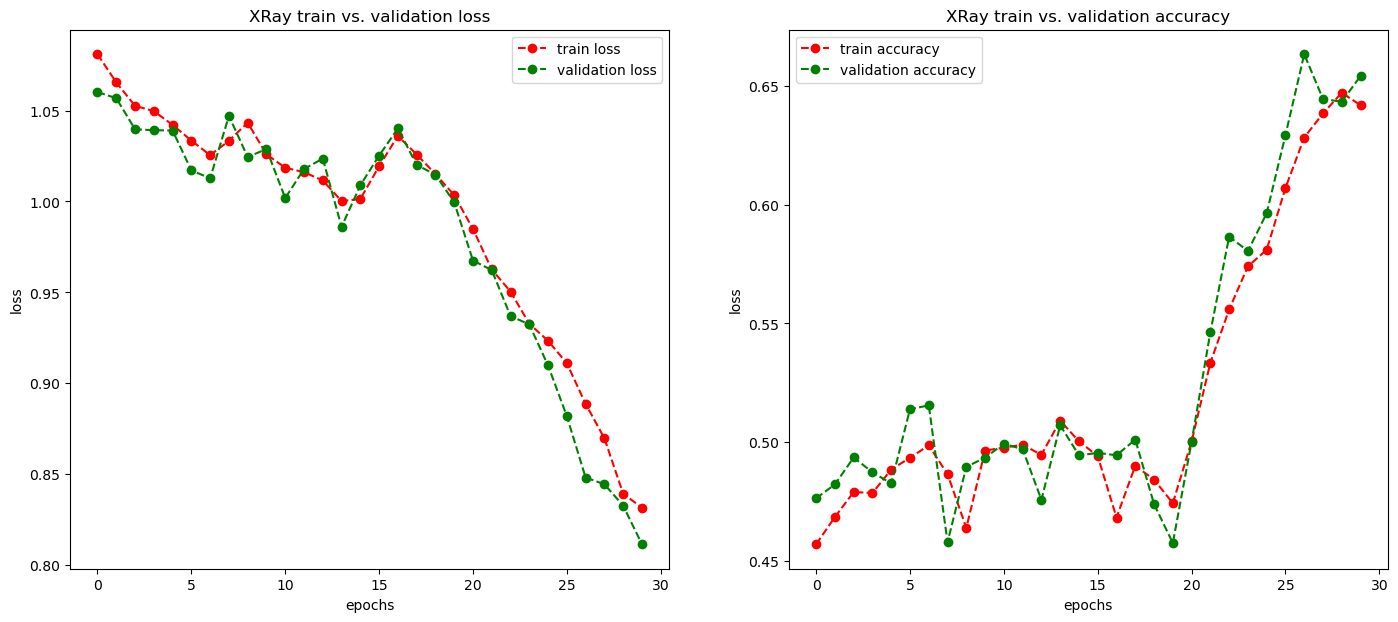

In [44]:
fig, axs = plt.subplots(2,1, figsize=(17,7))
plt.subplot(1, 2, 1)
plt.plot(output[0], linestyle = '--', marker = 'o', label = 'train loss', c = 'r')
plt.plot(output[2], linestyle = '--', marker = 'o', label = 'validation loss', c = 'g')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("XRay train vs. validation loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(output[1], linestyle = '--', marker = 'o', label = 'train accuracy', c = 'r')
plt.plot(output[3], linestyle = '--', marker = 'o', label = 'validation accuracy', c = 'g')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("XRay train vs. validation accuracy")
plt.legend()
    
plt.savefig('result_xray_1.png')
plt.show()
